# Region Based CNN (RCNN) Clasica + VOC2007

Propuesta por Girshick en 



Componentes:

| Componente                                                | Descripción técnica                                                                                                                                                                                                                              | Resultado                             |
| --------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ | ------------------------------------- |
| **1. Propuesta de regiones (Region Proposal)**            | Algoritmo externo (usualmente *Selective Search*) que genera ≈2 000 regiones candidatas por imagen que *podrían* contener un objeto. No usa redes neuronales.                                                                                    | Lista de cajas `(x1, y1, x2, y2)`     |
| **2. Extracción de características (Feature Extraction)** | Cada región propuesta se recorta, redimensiona a tamaño fijo (por ej. 224×224) y se pasa por una **CNN preentrenada** (AlexNet, VGG, o ResNet). Se guarda el vector de activaciones de una capa densa intermedia (por ejemplo, `fc7` de 4096 D). | Representación vectorial de la región |
| **3. Clasificación (Region Classification)**              | Se entrena un **SVM por clase** (one-vs-rest) sobre los vectores de características para decidir qué clase contiene cada región (o si es fondo).                                                                                                 | Probabilidad / score de clase         |
| **4. Localización (Bounding Box Regression)**             | Para cada clase, un regresor lineal predice los ajustes `(tx, ty, tw, th)` que corrigen la posición y tamaño de la caja respecto a la región propuesta original.                                                                                 | Caja ajustada                         |
| **5. Post-procesamiento (NMS y evaluación)**              | Se filtran duplicados con **Non-Maximum Suppression (NMS)** según el score y la intersección IoU ≥ 0.5. Se evalúa con mAP.                                                                                                                       | Cajas finales y métricas              |


### Pipeline:

Input: imagen.

Selective Search → genera ~2 000 propuestas.

Cada propuesta se recorta y normaliza (warp 224×224).

Cada recorte pasa por la CNN preentrenada → vector de características.

Esos vectores alimentan los SVMs (uno por clase).

Las regiones positivas se refinan con el regresor de cajas correspondiente.

Se aplican NMS y umbrales de score para obtener detecciones finales.

Se calculan métricas IoU/mAP.

### Entrenamiento

El entrenamiento clásico se divide en tres fases independientes:

Fine-tuning de la CNN en los recortes positivos/negativos (opcional).

Entrenamiento de SVMs con los vectores de features congelados.

Entrenamiento de regresores de cajas por clase.

### Glosario

| Concepto                          | Descripción técnica breve                                                                                   |
| --------------------------------- | ----------------------------------------------------------------------------------------------------------- |
| **Region Proposal**               | Candidata a contener un objeto; se genera con *Selective Search*.                                           |
| **Selective Search**              | Algoritmo que segmenta y agrupa regiones visualmente similares (~2 000 por imagen).                         |
| **RoI (Region of Interest)**      | Recorte de imagen correspondiente a una propuesta; se analiza individualmente.                              |
| **Feature Extraction**            | Paso de cada RoI por una CNN preentrenada (AlexNet, VGG, ResNet) para obtener su vector de características. |
| **Fine-tuning**                   | Ajuste de los pesos de la CNN usando ejemplos del nuevo dataset.                                            |
| **SVM (Support Vector Machine)**  | Clasificador lineal que separa clases; en R-CNN hay uno por clase (one-vs-rest).                            |
| **Bounding Box Regression**       | Regresión lineal que corrige la posición y tamaño de las cajas propuestas.                                  |
| **IoU (Intersection over Union)** | Superposición entre predicción y caja real: área(intersección)/área(unión).                                 |
| **Precision / Recall**            | Medidas de calidad: precisión = TP/(TP+FP), recall = TP/(TP+FN).                                            |
| **AP / mAP**                      | AP = área bajo la curva precisión-recall por clase; mAP = media sobre todas las clases.                     |
| **NMS (Non-Maximum Suppression)** | Filtra cajas duplicadas: conserva la de mayor score y elimina solapadas (IoU > 0.3–0.5).                    |
| **Region Warping**                | Redimensionar cada propuesta a tamaño fijo (ej. 224×224) antes de pasarla por la CNN.                       |
| **Hard Negative Mining**          | Reentrenar SVM con ejemplos negativos difíciles para mejorar discriminación.                                |


----------------------------------------------------------------------------------------------

En nuestro proyecto vamos a crear una RCNN usando Pytorch y torchvision, separando cada fase para comprender la arquitectura y la evolución de este tipo de redes.

-Dataset: PASCAL VOC 2007 (imágenes + anotaciones XML).
-Propuestas de región: generadas con Selective Search (≈ 2 000 por imagen).
-Extracción de características: CNN preentrenada (ResNet-50)
-Clasificación: conjunto de SVMs one-vs-rest entrenados sobre los vectores de características.
-Regresión de bounding boxes: un regresor lineal por clase que ajusta (tx, ty, tw, th) sobre las propuestas.
-Postprocesado: Non-Maximum Suppression y cálculo de métricas IoU / mAP.

| Sección                       | Descripción                                                        |
| ----------------------------- | ------------------------------------------------------------------ |
| **0. Setup**                  | Configuración del entorno, seeds y verificación de CUDA.           |
| **1. Dataset**                | Carga del conjunto VOC y parsing de anotaciones.                   |
| **2. Region Proposals**       | Implementación de *Selective Search*.                              |
| **3. Feature Extractor**      | Definición de la red preentrenada y preprocesamiento.              |
| **4. ROI Sampling + Targets** | Generación de ejemplos positivos/negativos y targets de regresión. |
| **5. SVM Training**           | Entrenamiento de clasificadores.                                   |
| **6. BBox Regression**        | Entrenamiento de regresores por clase.                             |
| **7. Inference**              | Scoring, ajuste de cajas y NMS.                                    |
| **8. Evaluation**             | Cálculo de mAP en subconjunto de test.                             |


Vamos a comenzar con el setup

In [1]:
import os, random, math, time, pathlib, shutil, json
import numpy as np
import torch
import torchvision as tv

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("CUDA disponible:", torch.cuda.is_available())
print("Device:", device)

VOC_ROOT = os.environ.get("VOC_ROOT", "./data/01")
print("VOC_ROOT:", VOC_ROOT)


CUDA disponible: True
Device: cuda
VOC_ROOT: ./data/01


Descargamos el dataset desde Kaggle (a dia de 10/11 el descargable desde pytorch no parece disponible)



#El datadaset VOC tiene versiones por año, por lo que debemos especificar el año que queremos usar.
#2007 es un standard para aprender detección de objetos, pero también está disponible VOC 2012.

en consola:

```bash
kaggle datasets download -d zaraks/pascal-voc-2007 -p ./data/01

unzip ./data/01/pascal-voc-2007.zip -d ./data/01
```


A continuación cargamos en dataset (las carpetas de este kaggle viene duplicas y traen algunos json para otro tipo de librerias que admiten formato COCO)

En nuestro caso nos quedamos solo con las carpetas 

"./data/01/VOCtrainval_06-Nov-2007"
"./data/01/VOCtest_06-Nov-2007"

Abajo validaremos esto:

Los resultados deben ser:

- Train: 5011
- Test: 4952

In [2]:
from torchvision.datasets import VOCDetection

train_root = "./data/01/VOCtrainval_06-Nov-2007"
test_root  = "./data/01/VOCtest_06-Nov-2007"

train_ds = VOCDetection(train_root, year="2007", image_set="trainval", download=False)
test_ds  = VOCDetection(test_root,  year="2007", image_set="test",     download=False)

print("Train:", len(train_ds))
print("Test:", len(test_ds))


Train: 5011
Test: 4952


Cada imagen en el dataset tiene relacionado un archivo XML en /Annotations con el mismo nombre:

Ej:

- JPEGImages/000001.jpg
- Annotations/000001.xml

Hay otras carpetas en el dataset que no usaremos en este notebook (relacionadas con segmentacion etc)

En particular las que vamos a usar son:

- JPEGImages →  imágenes

- Annotations →  XML 

- ImageSets → define qué imágenes pertenecen a train/test


Vamos a ver la estructura básica de uno de los xml:

```
<annotation>                                   → Raíz del archivo de anotación
 ├── <folder>                                  → Carpeta del dataset donde está la imagen (ej. "VOC2007")
 ├── <filename>                                → Nombre del archivo de imagen (.jpg)
 ├── <source>                                  → Metadatos sobre el origen de la imagen
 │     ├── <database>                          → Nombre de la base de datos original ("The VOC2007 Database")
 │     ├── <annotation>                        → Nombre del conjunto de anotaciones ("PASCAL VOC2007")
 │     ├── <image>                             → Fuente de la imagen (p. ej. "flickr")
 │     └── <flickrid>                          → ID numérico de la imagen en Flickr
 ├── <owner>                                   → Información del autor o propietario de la imagen
 │     ├── <flickrid>                          → Identificador del usuario en Flickr
 │     └── <name>                              → Nombre del autor (a veces “?” o vacío)
 ├── <size>                                    → Dimensiones originales de la imagen
 │     ├── <width>                             → Ancho en píxeles
 │     ├── <height>                            → Alto en píxeles
 │     └── <depth>                             → Número de canales (3 = RGB)
 ├── <segmented>                               → 1 si existe anotación de segmentación, 0 si solo hay detección
 └── <object>                                  → Uno o varios nodos, cada uno representa un objeto anotado
       ├── <name>                              → Clase del objeto (de las 20 clases VOC)
       ├── <pose>                              → Orientación del objeto ("Frontal", "Left", "Right", etc.)
       ├── <truncated>                         → 1 si el objeto está cortado por el borde de la imagen
       ├── <difficult>                         → 1 si es un objeto difícil de detectar (pequeño, ocluido…)
       └── <bndbox>                            → Coordenadas del rectángulo que delimita el objeto
             ├── <xmin>                        → Coordenada x mínima (esquina superior izquierda)
             ├── <ymin>                        → Coordenada y mínima
             ├── <xmax>                        → Coordenada x máxima (esquina inferior derecha)
             └── <ymax>                        → Coordenada y máxima

```


Vamos a crear una celda para visualizar imagen + bb

Los labels en nuestro caso serian las posiciones de los BBs.

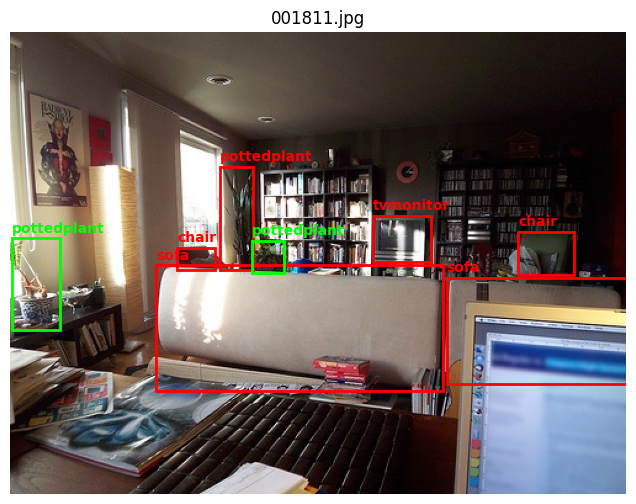

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def show_voc_sample(dataset, idx=0):
    img, target = dataset[idx]
    ann = target["annotation"]

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(img)
    ax.set_title(ann["filename"])

    objects = ann.get("object", [])
    if isinstance(objects, dict):
        objects = [objects]  

    for obj in objects:
        name = obj["name"]
        diff = int(obj["difficult"])
        bb = obj["bndbox"]
        xmin, ymin, xmax, ymax = [int(bb[k]) for k in ["xmin","ymin","xmax","ymax"]]

        color = "red" if diff == 1 else "lime"
        rect = patches.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            linewidth=2,
            edgecolor=color,
            facecolor="none"
        )
        ax.add_patch(rect)
        ax.text(xmin, ymin - 5, name, color=color, fontsize=10, weight="bold")

    plt.axis("off")
    plt.show()

# Ejemplo: muestra una imagen aleatoria
import random
idx = random.randint(0, len(test_ds) - 1)
show_voc_sample(test_ds, idx)


Nuestro modelo aprenderá el patrón visual que diferencia:

-una región correcta 

-de una región errónea 

Para calcular esta diferencia, se solapan las regiones correctas (labels) con regiones que proponemos a traves del algoritmo selectiveserach, esa diferencia es la que aprende a optimizar nuestro modelo, para que cuando le entren imagenes que no vio, sepa generalizar.

Vamos a usar selectivesearch para proponer regiones basadas en blobs de pixeles.

| Parámetro     | Qué controla                                                        | Impacto               |
| ------------- | ------------------------------------------------------------------- | --------------------- |
| `scale`       | sensibilidad de agrupación (más alto = menos regiones, más grandes) | velocidad vs. detalle |
| `sigma`       | suavizado previo de la imagen                                       | estabilidad de bordes |
| `min_size`    | tamaño mínimo de región                                             | evita blobs diminutos |
| `max_regions` | tope de regiones devueltas                                          | rendimiento           |


Vamos a generar regiones propuestas de una unica imagen y a comparar con las regiones relaes para ver el overlap.

En este ejemplo, procesamos una unica imagen.

Lo hacemos con selectivesearch, paquete tipo de python, luego cambiaremos a OpenCV

/root/.pyenv/versions/dlvs/lib/python3.12/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


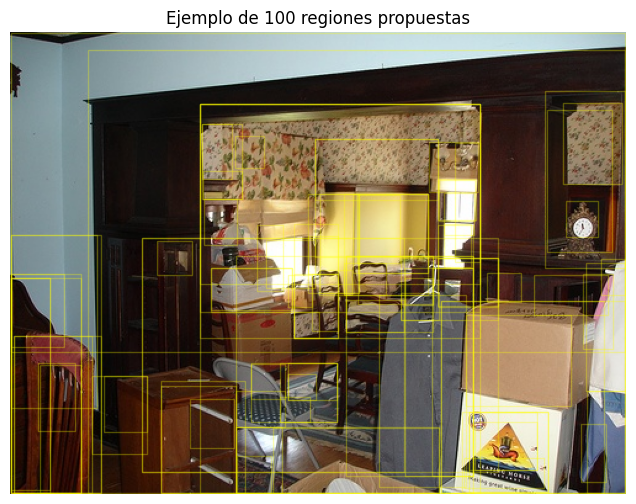

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import selectivesearch
from PIL import Image

def get_selective_search_boxes(pil_img, scale=500, sigma=0.9, min_size=20, max_regions=1500):
    img_np = np.array(pil_img)
    _, regions = selectivesearch.selective_search(img_np, scale=scale, sigma=sigma, min_size=min_size)
    boxes = []
    seen = set()
    for r in regions:
        x, y, w, h = r['rect']
        if (x, y, w, h) in seen or w < 20 or h < 20:
            continue
        seen.add((x, y, w, h))
        boxes.append([x, y, x+w, y+h])
    return np.array(boxes[:max_regions], dtype=np.int32)

def show_boxes_on_image(pil_img, boxes, num=100):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(pil_img)
    for (x1, y1, x2, y2) in boxes[:num]:
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                 linewidth=1, edgecolor='yellow',
                                 facecolor='none', alpha=0.3)
        ax.add_patch(rect)
    ax.set_title(f"Ejemplo de {num} regiones propuestas")
    plt.axis('off')
    plt.show()

img, _ = train_ds[0]
boxes = get_selective_search_boxes(img)
show_boxes_on_image(img, boxes, num=100)


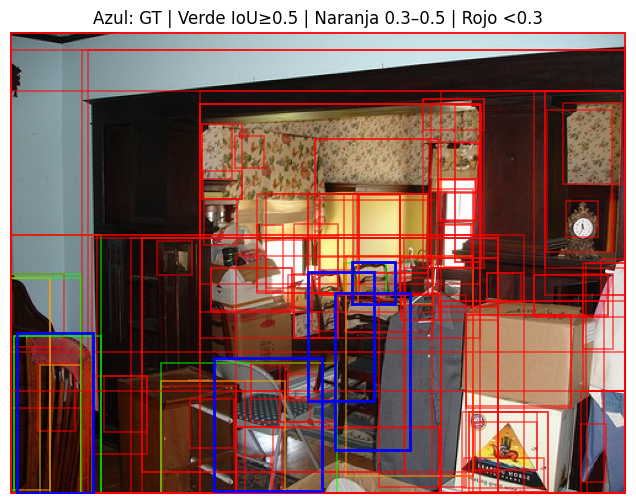

In [5]:
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    inter_w = max(0, xB - xA)
    inter_h = max(0, yB - yA)
    inter_area = inter_w * inter_h

    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    union = areaA + areaB - inter_area
    return inter_area / union if union > 0 else 0


def extract_gt_boxes(target):
    gt_boxes = []
    objs = target["annotation"]["object"]
    if isinstance(objs, dict):
        objs = [objs]
    for obj in objs:
        bb = obj["bndbox"]
        gt_boxes.append([
            int(bb["xmin"]), int(bb["ymin"]),
            int(bb["xmax"]), int(bb["ymax"])
        ])
    return gt_boxes


def visualize_iou(img, boxes, gt_boxes, num=100):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(img)

    for (x1, y1, x2, y2) in boxes[:num]:
        # calcula el IoU máximo con las GT
        max_iou = max(compute_iou([x1, y1, x2, y2], gt) for gt in gt_boxes)
        # color por nivel de IoU
        if max_iou >= 0.5:
            color = 'lime'
        elif max_iou >= 0.3:
            color = 'orange'
        else:
            color = 'red'

        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=1.2, edgecolor=color,
            facecolor='none', alpha=0.6
        )
        ax.add_patch(rect)

    # Dibuja también las cajas reales en azul
    for (x1, y1, x2, y2) in gt_boxes:
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor='blue',
            facecolor='none'
        )
        ax.add_patch(rect)

    ax.set_title("Azul: GT | Verde IoU≥0.5 | Naranja 0.3–0.5 | Rojo <0.3")
    plt.axis('off')
    plt.show()


# Ejecuta sobre tu imagen 0
img, target = train_ds[0]
boxes = get_selective_search_boxes(img)
gt_boxes = extract_gt_boxes(target)
visualize_iou(img, boxes, gt_boxes, num=150)


Como vemos en la imagen, las azules, son los bb correctos, los verdes los bb propuestos por selective search que coinciden en mas de un 50% con los correctos, rojos son negativos, y naranjas algo itermedio.

Hay pocas bb propuestas que coincidan con bb correctos, lo que haría que perdieramos bastantes objetos ya taggeados correctamente.

Esta es una de las limitaciones de las RCNN clasicas,  mejoraron en el futuro con evoluciones en la arquitectura que veremos en otros notebooks.

Fuente:
```

“Limitations [of R-CNN] include: slow testing speed … high memory usage … and region proposals generated by Selective Search are not always accurate.”

https://personales.upv.es/thinkmind/dl/conferences/innov/innov_2023/innov_2023_1_10_70007.pdf?utm_source=chatgpt.com

```

Vamos a crear el Dataset de regiones.

Clasificamos las regiones entre negativas (probablemente fondo) y positivas (probablemente objeto)

Usamos OpenCV para generar propuestas.

Nota la cantidad de codigo necesaria, esto es debido a que estamos reproduciendo una verison del pipeline de RCNN clásica que a dia de hoy ya no se usa como tal, si no que esta abstraido con otros metodos en otros tipos de pipeliens de detección de objetos.

Basicamente lo que hacemos aqui es sacar propuestas y clasificarlas entre negativas y positivas.

In [6]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import csv, os, numpy as np, torch
from pathlib import Path
from PIL import Image
import cv2
from torchvision.ops import box_iou

POS_THR = 0.5
NEG_THR = 0.3
MAX_POS_PER_IMG = 16
MAX_NEG_PER_IMG = 64
MAX_REGIONS = 1200
CROP_SIZE = 224
JPG_QUALITY = 90
OUT_DIR = Path("./data/01/rcnn_regions")
OUT_POS = OUT_DIR/"pos"
OUT_NEG = OUT_DIR/"neg"
META_PATH = OUT_DIR/"metadata.csv"

def ss_opencv(pil_img, mode="f", max_regions=1200):
    img = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast() if mode=="f" else ss.switchToSelectiveSearchQuality()
    rects = ss.process()[:max_regions]
    if len(rects)==0: return np.zeros((0,4), dtype=np.int32)
    return np.stack([np.array([x, y, x+w, y+h]) for (x,y,w,h) in rects], axis=0).astype(np.int32)

def voc_gt_boxes_labels(target):
    objs = target["annotation"]["object"]
    if isinstance(objs, dict): objs = [objs]
    boxes, labels = [], []
    for o in objs:
        bb = o["bndbox"]
        boxes.append([int(bb["xmin"]), int(bb["ymin"]), int(bb["xmax"]), int(bb["ymax"])])
        labels.append(o["name"])
    return np.array(boxes, dtype=np.int32), labels

def clamp_box(b, w, h):
    x1 = max(0, min(int(b[0]), w-1)); y1 = max(0, min(int(b[1]), h-1))
    x2 = max(0, min(int(b[2]), w));    y2 = max(0, min(int(b[3]), h))
    if x2 <= x1+1: x2 = min(w, x1+2)
    if y2 <= y1+1: y2 = min(h, y1+2)
    return [x1, y1, x2, y2]

def crop_and_resize(pil_img, box, size):
    w, h = pil_img.size
    b = clamp_box(box, w, h)
    return pil_img.crop((b[0], b[1], b[2], b[3])).resize((size, size), Image.BILINEAR), b

def process_image(i, split_name, voc_root, target, mode="f"):
    img_name = target["annotation"]["filename"]
    img_path = os.path.join(voc_root, "JPEGImages", img_name)
    pil_img = Image.open(img_path).convert("RGB")

    props = ss_opencv(pil_img, mode=mode, max_regions=MAX_REGIONS)
    gt_boxes, gt_labels = voc_gt_boxes_labels(target)

    rows = []; pos_ct = 0; neg_ct = 0
    if props.shape[0] == 0:
        return rows, pos_ct, neg_ct

    if gt_boxes.size == 0:
        sel = np.arange(props.shape[0])[:MAX_NEG_PER_IMG]
        for k, p in enumerate(props[sel]):
            crop, b = crop_and_resize(pil_img, p, CROP_SIZE)
            out_path = OUT_NEG/f"{split_name}_{i:05d}_neg_bg_{k:04d}.jpg"
            crop.save(out_path, quality=JPG_QUALITY)
            rows.append([split_name, i, img_name, "neg", "background", f"{0.0:.4f}", b[0], b[1], b[2], b[3], str(out_path)])
        return rows, 0, len(sel)

    props_t = torch.as_tensor(props, dtype=torch.float32)
    gt_t    = torch.as_tensor(gt_boxes, dtype=torch.float32)
    ious = box_iou(props_t, gt_t).numpy()
    max_iou = ious.max(axis=1); argmax = ious.argmax(axis=1)

    pos_idx = np.where(max_iou >= POS_THR)[0]
    neg_idx = np.where(max_iou <= NEG_THR)[0]
    if pos_idx.size > MAX_POS_PER_IMG: pos_idx = np.random.choice(pos_idx, size=MAX_POS_PER_IMG, replace=False)
    if neg_idx.size > MAX_NEG_PER_IMG: neg_idx = np.random.choice(neg_idx, size=MAX_NEG_PER_IMG, replace=False)

    for k, j in enumerate(pos_idx):
        p = props[j]; lab = gt_labels[int(argmax[j])]; iou = float(max_iou[j])
        crop, b = crop_and_resize(pil_img, p, CROP_SIZE)
        out_path = OUT_POS/f"{split_name}_{i:05d}_pos_{lab}_{k:04d}.jpg"
        crop.save(out_path, quality=JPG_QUALITY)
        rows.append([split_name, i, img_name, "pos", lab, f"{iou:.4f}", b[0], b[1], b[2], b[3], str(out_path)])
        pos_ct += 1

    for k, j in enumerate(neg_idx):
        p = props[j]; iou = float(max_iou[j])
        crop, b = crop_and_resize(pil_img, p, CROP_SIZE)
        out_path = OUT_NEG/f"{split_name}_{i:05d}_neg_bg_{k:04d}.jpg"
        crop.save(out_path, quality=JPG_QUALITY)
        rows.append([split_name, i, img_name, "neg", "background", f"{iou:.4f}", b[0], b[1], b[2], b[3], str(out_path)])
        neg_ct += 1

    return rows, pos_ct, neg_ct

def build_region_dataset_opencv_mp(ds, split_name, voc2007_root, start=0, stop=None, num_workers=8, mode="f"):
    OUT_POS.mkdir(parents=True, exist_ok=True); OUT_NEG.mkdir(parents=True, exist_ok=True)
    stop = len(ds) if stop is None else min(stop, len(ds))
    wrote_header = not META_PATH.exists()
    total_pos = total_neg = 0
    with open(META_PATH, "a", newline="") as f:
        wr = csv.writer(f)
        if wrote_header:
            wr.writerow(["split","img_idx","img_name","type","label","iou","x1","y1","x2","y2","path"])
        with ProcessPoolExecutor(max_workers=num_workers) as ex:
            futs = [ex.submit(process_image, i, split_name, voc2007_root, ds[i][1], mode) for i in range(start, stop)]
            for fu in as_completed(futs):
                rows, p, n = fu.result()
                if rows:
                    wr.writerows(rows)
                total_pos += p; total_neg += n
    print("split:", split_name, "imgs:", stop-start, "pos:", total_pos, "neg:", total_neg, "dir:", str(OUT_DIR))


Notesé que solo vamos a procesar stop=20 imagenes, el proceso clásico en RCNN es CPU bond, generara un dataset enorme de muchos GB además de tardar un tiempo considerable.

Este es otro problema de las RCNN

Fuente

```
Region proposal methods typically rely on … in a CPU implementation [Selective Search] is an order of magnitude slower, at 2 seconds per image.

https://arxiv.org/pdf/1506.01497?utm_source=chatgpt.com
```

In [7]:
voc2007_root_train = "./data/01/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007"
build_region_dataset_opencv_mp(train_ds, split_name="train", voc2007_root=voc2007_root_train, start=0, stop=20, mode="f")


split: train imgs: 20 pos: 210 neg: 1280 dir: data/01/rcnn_regions


Ahora que ya tenemos nuestro DS de prueba con los proposals, necesitamos usar una red pre-entrenada (RESNET50) y descabezarla.

Congelaremos las features de la red y la pondremos en modo eval para evitar que batchnorms y dropouts afecten.

Obtendremos de aquí un vector de features por cada crop, y los guardaremos junto a la etiqueta del crop (positivo/negativo)

Aqui no estamos reentrenando resnet, simplemente usandola para guardar las features de nuestros crops  haciendo uso del entrenamiento que ya tiene.

In [8]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torchvision.models import ResNet50_Weights
from torchsummary import summary

device = "cuda" if torch.cuda.is_available() else "cpu"

num_classes = 21
weights = ResNet50_Weights.IMAGENET1K_V2
normalize = weights.transforms()
print(normalize)

R50_MEAN = normalize.mean
R50_STD = normalize.std
print(R50_MEAN, R50_STD)

#Quitamos la capa de clasificación
backbone = nn.Sequential(*list(models.resnet50(weights=weights).children())[:-1]).to(device)

#Congelamos los parametros de la red
for p in backbone.parameters():
    p.requires_grad = False

#Ponemos la red en modo evaluación porque:
# - Desactiva Dropout si lo hubiera.
# - Garantiza comportamiento determinista al extraer features
# - Si tuviera BatchNorm, usaría la media y desviación de train.
backbone.eval()

print(summary(backbone, (3, 224, 224)))

#Aplicamos el pipeline de IMGNET a cada crop, unsqueeze agrega una dimension, 1, que sera el batch (1 imagen)
def to_tensor(pil_img):
    return normalize(pil_img).unsqueeze(0)

#Aplicamos la red a cada crop, flatten(1) aplana todas las dimensiones excepto el batch.
@torch.no_grad()
def encode(batch_tensor):
    x = batch_tensor.to(device)
    f = backbone(x).flatten(1)
    return f.float()


ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
[0.485, 0.456, 0.406] [0.229, 0.224, 0.225]
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2

Normalizamos y Extraemos ahora las features de cada crop para guardarlas clasificadas entre pos/neg

In [9]:
from pathlib import Path
from PIL import Image
import torch
import numpy as np
import csv

in_dir = Path("./data/01/rcnn_regions")
out_dir = Path("./data/01/features")
out_dir.mkdir(parents=True, exist_ok=True)

csv_path = out_dir / "features_meta.csv"

rows = []

for typ in ["pos", "neg"]:
    for img_path in (in_dir / typ).glob("*.jpg"):
        pil_img = Image.open(img_path).convert("RGB")
        tensor = to_tensor(pil_img)
        feats = encode(tensor).cpu().numpy().squeeze()   # [2048]
        
        
        npy_path = out_dir / (img_path.stem + ".npy")
        np.save(npy_path, feats)

        label = 1 if typ == "pos" else 0
        rows.append([img_path.name, typ, label, str(npy_path)])

with open(csv_path, "w", newline="") as f:
    wr = csv.writer(f)
    wr.writerow(["img_name", "type", "label", "feature_path"])
    wr.writerows(rows)

print(f"Guardadas {len(rows)} features en {out_dir}")



Guardadas 1490 features en data/01/features


Ahora tenemos que entrenar un SVM binário (Support Vector Machine)

Sera la primera de nuestras "capas" en RCNN clásica que distinguirá si hay un objeto o no.

Ahora mismo ya sabemos que pos = hay objeto y neg = no hay objeto

Pero este comportamiento tiene que ser aprendido para poder generarlizar.

In [10]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib

meta = pd.read_csv("./data/01/features/features_meta.csv")
X = np.stack([np.load(p) for p in meta["feature_path"].tolist()], axis=0)
y = meta["label"].to_numpy().astype(int)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("svm", LinearSVC(C=0.5, class_weight="balanced", max_iter=20000))
])

clf.fit(X_tr, y_tr)
y_pr = clf.predict(X_te)

print(confusion_matrix(y_te, y_pr))
print(classification_report(y_te, y_pr, digits=3))

Path("./data/01/models").mkdir(parents=True, exist_ok=True)
joblib.dump(clf, "./data/01/models/svm_pos_neg.joblib")


[[248   8]
 [  4  38]]
              precision    recall  f1-score   support

           0      0.984     0.969     0.976       256
           1      0.826     0.905     0.864        42

    accuracy                          0.960       298
   macro avg      0.905     0.937     0.920       298
weighted avg      0.962     0.960     0.960       298



['./data/01/models/svm_pos_neg.joblib']

Ahora ya tenemos un modelo que sabe distinguir si hay objeto o no.

Lo siguiente es entrenar un SVM que distinga cada una de las clases que tenemos, además se incluye también el fondo, para que si, por error el primero clasificador dejo pasar algo, aqui aprenda también a rechazar el fondo.

"One_vs_Rest"

In [11]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from joblib import Parallel, delayed
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib

meta = pd.read_csv("./data/01/rcnn_regions/metadata.csv", usecols=["img_name","type","label","iou","path"])
feat = pd.read_csv("./data/01/features/features_meta.csv", usecols=["img_name","feature_path"])

meta["crop_name"] = meta["path"].apply(lambda p: os.path.basename(str(p)))
feat = feat.rename(columns={"img_name":"crop_name"})

df = pd.merge(meta, feat, on="crop_name", how="inner")
df["iou"] = df["iou"].astype(float)

classes = sorted(df.loc[df["type"]=="pos","label"].unique().tolist())
models_dir = Path("./data/01/models/ovr_svms"); models_dir.mkdir(parents=True, exist_ok=True)

def train_one(cls):
    pos = df[(df["type"]=="pos") & (df["label"]==cls) & (df["iou"]>=0.5)]
    neg = df[((df["type"]=="neg") | (df["label"]!=cls)) & (df["iou"]<=0.3)]
    sub = pd.concat([pos, neg], ignore_index=True)
    if sub.empty or sub["label"].nunique()==1:
        return cls, None
    X = np.stack([np.load(p) for p in sub["feature_path"].tolist()], axis=0)
    y = ((sub["type"]=="pos") & (sub["label"]==cls) & (sub["iou"]>=0.5)).astype(int).to_numpy()
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    clf = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("svm", LinearSVC(C=0.5, class_weight="balanced", max_iter=20000))
    ])
    clf.fit(X_tr, y_tr)
    y_pr = clf.predict(X_te)
    rep = classification_report(y_te, y_pr, output_dict=True)
    joblib.dump(clf, models_dir/f"svm_{cls}.joblib")
    return cls, rep

results = Parallel(n_jobs=min(8, os.cpu_count() or 2), backend="loky")(delayed(train_one)(c) for c in classes)
report = {c: r for c, r in results if r is not None}
summary = {c: round(report[c]['1']['f1-score'], 3) if c in report and '1' in report[c] else None for c in classes}
print("F1 por clase (positiva):", summary)


F1 por clase (positiva): {'aeroplane': 1.0, 'bicycle': 0.889, 'car': 0.857, 'cat': 1.0, 'chair': 1.0, 'dog': 0.8, 'horse': 0.8, 'person': 0.583, 'train': 0.5, 'tvmonitor': 1.0}


Ahora hacemos una regresión para los BBs

In [13]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import joblib
import xml.etree.ElementTree as ET

def iou_xyxy(a, b):
    xA = max(a[0], b[0]); yA = max(a[1], b[1])
    xB = min(a[2], b[2]); yB = min(a[3], b[3])
    iw = max(0, xB-xA); ih = max(0, yB-yA)
    inter = iw*ih
    ua = max(0,(a[2]-a[0]))*max(0,(a[3]-a[1])) + max(0,(b[2]-b[0]))*max(0,(b[3]-b[1])) - inter
    return inter/ua if ua>0 else 0.0

def to_xywh(box):
    x1,y1,x2,y2 = box
    w = max(1.0, x2-x1); h = max(1.0, y2-y1)
    cx = x1 + 0.5*w; cy = y1 + 0.5*h
    return cx,cy,w,h

def deltas_from_boxes(prop, gt):
    px,py,pw,ph = to_xywh(prop)
    gx,gy,gw,gh = to_xywh(gt)
    tx = (gx - px)/pw
    ty = (gy - py)/ph
    tw = np.log(gw/pw)
    th = np.log(gh/ph)
    return np.array([tx,ty,tw,th], dtype=np.float32)

def parse_voc_xml(xml_path):
    tree = ET.parse(xml_path); root = tree.getroot()
    boxes, labels = [], []
    for obj in root.findall("object"):
        name = obj.find("name").text
        bb = obj.find("bndbox")
        x1 = int(bb.find("xmin").text); y1 = int(bb.find("ymin").text)
        x2 = int(bb.find("xmax").text); y2 = int(bb.find("ymax").text)
        boxes.append([x1,y1,x2,y2]); labels.append(name)
    return np.array(boxes, dtype=np.float32), labels

voc2007_root = "./data/01/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007"
ann_dir = Path(voc2007_root)/"Annotations"

meta = pd.read_csv("./data/01/rcnn_regions/metadata.csv", usecols=["img_name","type","label","iou","path","x1","y1","x2","y2"])
feat = pd.read_csv("./data/01/features/features_meta.csv", usecols=["img_name","feature_path"])
meta["crop_name"] = meta["path"].apply(lambda p: os.path.basename(str(p)))
feat = feat.rename(columns={"img_name":"crop_name"})
df = pd.merge(meta, feat, on="crop_name", how="inner")
df["iou"] = df["iou"].astype(float)

pos_df = df[(df["type"]=="pos") & (df["iou"]>=0.5)].copy()
if pos_df.empty:
    raise RuntimeError("No hay positivos con IoU>=0.5 para entrenar el regresor.")

gt_cache = {}
def best_gt_same_class(img_name, cls_label, prop_box):
    if img_name not in gt_cache:
        stem = os.path.splitext(img_name)[0]
        xml_path = ann_dir/f"{stem}.xml"
        boxes, labels = parse_voc_xml(xml_path)
        gt_cache[img_name] = (boxes, labels)
    boxes, labels = gt_cache[img_name]
    idxs = [i for i,l in enumerate(labels) if l==cls_label]
    if not idxs:
        return None
    best_iou, best_box = -1.0, None
    for i in idxs:
        giou = iou_xyxy(prop_box, boxes[i])
        if giou > best_iou:
            best_iou, best_box = giou, boxes[i]
    return best_box

rows = []
for r in pos_df.itertuples(index=False):
    prop = np.array([r.x1, r.y1, r.x2, r.y2], dtype=np.float32)
    gt = best_gt_same_class(r.img_name, r.label, prop)
    if gt is None:
        continue
    rows.append((r.label, r.feature_path, deltas_from_boxes(prop, gt)))

if not rows:
    raise RuntimeError("No se pudieron emparejar propuestas con GT de la misma clase.")

labels_list = [t[0] for t in rows]
paths_list  = [t[1] for t in rows]
deltas_list = np.stack([t[2] for t in rows], axis=0)

X_all = np.stack([np.load(p) for p in paths_list], axis=0)
y_all = deltas_list

df_reg = pd.DataFrame({"label": labels_list, "feature_path": paths_list})
classes = sorted(df_reg["label"].unique().tolist())

out_dir = Path("./data/01/models/bbox_regressors"); out_dir.mkdir(parents=True, exist_ok=True)
metrics = {}

for cls in classes:
    idx = [i for i,l in enumerate(labels_list) if l==cls]
    if len(idx) < 10:
        continue
    X = X_all[idx]
    y = y_all[idx]
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
    reg = Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("ridge", Ridge(alpha=1.0, random_state=42))
    ])
    reg.fit(X_tr, y_tr)
    y_pr = reg.predict(X_te)
    mae = float(mean_absolute_error(y_te, y_pr))
    metrics[cls] = mae
    joblib.dump(reg, out_dir/f"reg_{cls}.joblib")

print("MAE por clase (tx,ty,tw,th agregados):", metrics)
print("Guardados en:", str(out_dir))


MAE por clase (tx,ty,tw,th agregados): {'aeroplane': 0.19931961596012115, 'bicycle': 1.1484493017196655, 'car': 0.22235968708992004, 'cat': 0.12869517505168915, 'chair': 0.10696256905794144, 'dog': 0.18433818221092224, 'horse': 0.16574037075042725, 'person': 0.07583318650722504, 'tvmonitor': 0.07582785934209824}
Guardados en: data/01/models/bbox_regressors


/root/.pyenv/versions/dlvs/lib/python3.12/site-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


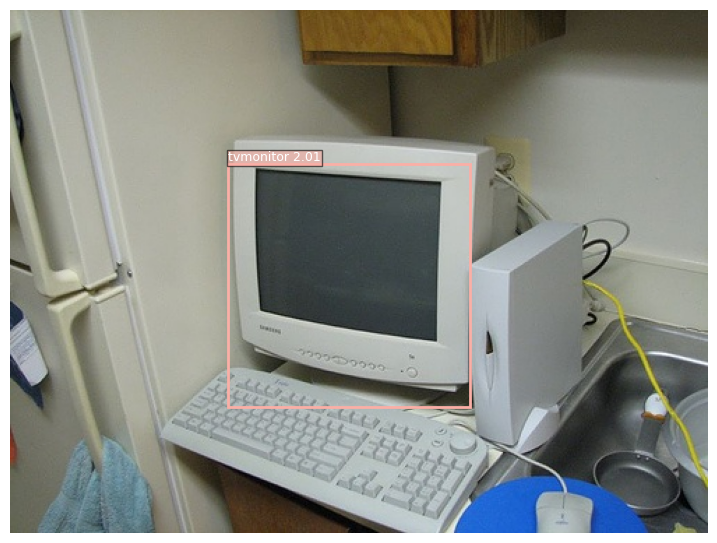

Detecciones: 1


In [29]:
import os, json, joblib, numpy as np, torch
from pathlib import Path
from torchvision.ops import nms
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

models_dir = Path("./data/01/models/ovr_svms")
reg_dir = Path("./data/01/models/bbox_regressors")
voc_root = "./data/01/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007"
thr_path = models_dir/"best_thresholds.json"

try:
    best_thresholds
except NameError:
    if thr_path.exists():
        best_thresholds = json.load(open(thr_path))
    else:
        best_thresholds = {}
if best_thresholds and not thr_path.exists():
    json.dump(best_thresholds, open(thr_path,"w"))

svm_paths = sorted(models_dir.glob("svm_*.joblib"))
cls_names = [p.stem.replace("svm_","") for p in svm_paths]
svms = {c: joblib.load(p) for c,p in zip(cls_names, svm_paths)}
regs = {}
for c in cls_names:
    p = reg_dir/f"reg_{c}.joblib"
    regs[c] = joblib.load(p) if p.exists() else None

def clamp_boxes(boxes, W, H):
    b = boxes.copy()
    b[:,0] = np.clip(b[:,0], 0, W-1)
    b[:,1] = np.clip(b[:,1], 0, H-1)
    b[:,2] = np.clip(b[:,2], 1, W)
    b[:,3] = np.clip(b[:,3], 1, H)
    b[:,2] = np.maximum(b[:,2], b[:,0]+1)
    b[:,3] = np.maximum(b[:,3], b[:,1]+1)
    return b

def apply_deltas(props, deltas):
    px = (props[:,0] + props[:,2]) * 0.5
    py = (props[:,1] + props[:,3]) * 0.5
    pw = np.maximum(1.0, props[:,2] - props[:,0])
    ph = np.maximum(1.0, props[:,3] - props[:,1])
    gx = deltas[:,0] * pw + px
    gy = deltas[:,1] * ph + py
    gw = pw * np.exp(deltas[:,2])
    gh = ph * np.exp(deltas[:,3])
    x1 = gx - 0.5 * gw
    y1 = gy - 0.5 * gh
    x2 = gx + 0.5 * gw
    y2 = gy + 0.5 * gh
    return np.stack([x1,y1,x2,y2], axis=1)

def crop_boxes(pil_img, boxes, size=224):
    W,H = pil_img.size
    out = []
    for x1,y1,x2,y2 in boxes:
        x1 = max(0,min(int(x1),W-1)); y1 = max(0,min(int(y1),H-1))
        x2 = max(0,min(int(x2),W));   y2 = max(0,min(int(y2),H))
        if x2<=x1+1: x2=min(W,x1+2)
        if y2<=y1+1: y2=min(H,y1+2)
        out.append(pil_img.crop((x1,y1,x2,y2)).resize((size,size), Image.BILINEAR))
    return out

def encode_batch(crops, batch_size=64):
    feats = []
    for i in range(0, len(crops), batch_size):
        batch = torch.cat([to_tensor(im) for im in crops[i:i+batch_size]], dim=0)
        f = encode(batch).cpu().numpy()
        feats.append(f)
    return np.concatenate(feats, axis=0) if feats else np.zeros((0,2048),dtype=np.float32)

def infer_image(pil_img, max_regions=800, iou_nms=0.3, topk=5, show=True):
    props = get_selective_search_boxes(pil_img, max_regions=max_regions)
    if props.shape[0]==0:
        return []
    crops = crop_boxes(pil_img, props, size=224)
    X = encode_batch(crops, batch_size=64)
    W,H = pil_img.size
    dets = []
    for cls in cls_names:
        clf = svms[cls]
        scores = clf.decision_function(X)
        thr = float(best_thresholds.get(cls, 0.0))
        keep = np.where(scores >= thr)[0]
        if keep.size==0:
            continue
        boxes = props[keep].astype(np.float32)
        if regs.get(cls) is not None:
            deltas = regs[cls].predict(X[keep])
            boxes = apply_deltas(boxes, deltas)
            boxes = clamp_boxes(boxes, W, H)
        b = torch.tensor(boxes, dtype=torch.float32)
        s = torch.tensor(scores[keep], dtype=torch.float32)
        k = nms(b, s, iou_nms)
        b = b[k].numpy()
        s = s[k].numpy()
        order = np.argsort(-s)[:topk]
        for j in order:
            dets.append((cls, float(s[j]), b[j].astype(int)))
    if show:
        fig, ax = plt.subplots(figsize=(9,7))
        ax.imshow(pil_img); ax.axis('off')
        rng = np.random.default_rng(0)
        color_map = {c: rng.random(3,) for c in cls_names}
        for cls,score,box in dets:
            x1,y1,x2,y2 = box.tolist()
            rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, edgecolor=color_map[cls], facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1-2, f"{cls} {score:.2f}", fontsize=9, color='white', bbox=dict(facecolor=color_map[cls], alpha=0.6, pad=1))
        plt.show()
    return dets

img_name = "000039.jpg"
pil = Image.open(os.path.join(voc_root,"JPEGImages",img_name)).convert("RGB")
detections = infer_image(pil, max_regions=800, iou_nms=0.3, topk=5, show=True)
print(f"Detecciones: {len(detections)}")
